In [24]:
! pip3 install xgboost --user

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
#Load and split the data
training_data = pd.read_csv("train.csv")
testing_data = pd.read_csv("test.csv")
costa_rica_data = training_data.drop(['Target'], axis=1)
costa_rica_target = training_data['Target']

In [4]:
#Clean the data to either replace or remove string columns
costa_rica_data.select_dtypes(exclude=[np.number]).head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


In [5]:
costa_rica_data = costa_rica_data.select_dtypes(include=[np.number], exclude=[np.object]).fillna(0)
costa_rica_data.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,190000.0,0,3,0,1,1,0,0.0,0,1,...,43,100,1849,1,100,0,1.000000,0.0,100.0,1849
1,135000.0,0,4,0,1,1,1,1.0,0,1,...,67,144,4489,1,144,0,1.000000,64.0,144.0,4489
2,0.0,0,8,0,1,1,0,0.0,0,0,...,92,121,8464,1,0,0,0.250000,64.0,121.0,8464
3,180000.0,0,5,0,1,1,1,1.0,0,2,...,17,81,289,16,121,4,1.777778,1.0,121.0,289
4,180000.0,0,5,0,1,1,1,1.0,0,2,...,37,121,1369,16,121,4,1.777778,1.0,121.0,1369


In [6]:
#Split data into 70% train, 30% validation (test) split
X_train, X_test, y_train, y_test = train_test_split(costa_rica_data.values, costa_rica_target.values, test_size= 0.3, random_state=42)
X_train.shape

(6689, 137)

In [7]:
#Build ML pipeline to perform cross validation across different classification algorithms
score_func = accuracy_score

def quick_eval(pipeline, x, y, score_func=score_func):
    '''Displays accuracy scores for KFold across
    select classification algorithms.'''
    
    result = 0
    nfold = 5
    
    fold_score = []
    
    index = 0
    #split the data set into nfold number of training and test sets for model fit + predict
    for train, test in KFold(nfold).split(x):
        pipeline.fit(x[train], y[train])
        result += score_func(pipeline.predict(x[test]), y[test])
        index += 1
        fold_score.append(result/index)
    
    #create a dataframe for the result of each fold
    fold_df = pd.DataFrame(fold_score, columns=[pipeline.named_steps['classification'].__class__.__name__],
                    index=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])
    
    #create a dataframe for the average score across all folds
    average_score = [result/nfold]
    summary_df = pd.DataFrame(average_score, columns=[pipeline.named_steps['classification'].__class__.__name__], 
                        index=['Accuracy'])
    
    #create a summary dataframe containing a fold-level and average fold summary
    summary_df = pd.concat([fold_df, summary_df])
    return summary_df
    
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC()
]

score_df = pd.DataFrame()

for c in classifiers:
    pipe = Pipeline(steps = [
        ('minmax', MinMaxScaler()),
        ('stdscaler', StandardScaler()),
        ('classification', c)
    ])

    result_df = quick_eval(pipe, X_train, y_train)
    score_df = pd.concat([score_df, result_df], axis=1)
    
score_df

/Users/krishi/Library/Python/2.7/lib/python/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/krishi/Library/Python/2.7/lib/python/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/krishi/Library/Python/2.7/lib/python/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/krishi/Library/Python/2.7/lib/python/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warn

,DecisionTreeClassifier,RandomForestClassifier,XGBClassifier,LogisticRegression,KNeighborsClassifier,SVC
Fold 1,0.857250,0.860987,0.689836,0.656951,0.723468,0.724215
Fold 2,0.861360,0.849402,0.701046,0.661061,0.727952,0.728326
Fold 3,0.864973,0.852516,0.708022,0.668909,0.727454,0.734180
Fold 4,0.863976,0.854073,0.710575,0.675075,0.733931,0.739910
Fold 5,0.866499,0.854089,0.717750,0.681122,0.738080,0.744658
Accuracy,0.866499,0.854089,0.717750,0.681122,0.738080,0.744658


<Figure size 504x504 with 0 Axes>

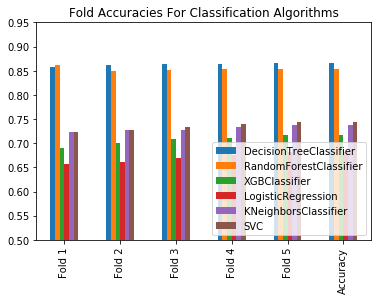

In [8]:
#Analyze fold accuracies and algorithm performances (overall and across folds)
plt.figure(figsize = (7,7))
score_df.plot(kind='bar', yticks=np.arange(0.5, 1, 0.05), ylim = 0.5,
                                  title = "Fold Accuracies For Classification Algorithms")
plt.legend(loc='lower right')
plt.show()

In [9]:
#Fit a Decision Tree with default parameters to get a baseline idea of performance
clf = DecisionTreeClassifier()
model = clf.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
score = model.score(X_test, y_test)
score

0.89714086471408649

In [10]:
#Optimize hyperparameters of a DecisionTree model using Grid Search in Python
def optimizeParameter():

    import warnings
    warnings.filterwarnings("ignore")

    # load libraries
    from sklearn import decomposition, datasets
    from sklearn import tree
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV, cross_val_score
    from sklearn.preprocessing import StandardScaler

    # Load the data
    X_train = costa_rica_data.values
    y_train = costa_rica_target.values

    # Create an scaler object
    sc = StandardScaler()

    # Create a logistic regression object with an L2 penalty
    decisiontree = tree.DecisionTreeClassifier()

    # Create a pipeline of three steps. First, standardize the data.
    # Second, tranform the data with PCA.
    # Third, train a Decision Tree Classifier on the data.
    pipe = Pipeline(steps=[('sc', sc),
                           ('decisiontree', decisiontree)])

    # Create lists of parameter for Decision Tree Classifier
    criterion = ['gini', 'entropy']
    max_depth = [35, 50, 65, 70, 75, 90]

    # Create a dictionary of all the parameter options 
    # Note has you can access the parameters of steps of a pipeline by using '__’
    parameters = dict(decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

    # Conduct Parameter Optmization With Pipeline
    # Create a grid search object
    clf = GridSearchCV(pipe, parameters)

    # Fit the grid search
    clf.fit(X_train, y_train)

    # View The Best Parameters
    print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
    print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
    print(); print(clf.best_estimator_.get_params()['decisiontree'])

    # Use Cross Validation To Evaluate Model
    CV_Result = cross_val_score(clf, X_train, y_train, cv=4, n_jobs=-1)
    print(); print(CV_Result)
    print(); print(CV_Result.mean())
    print(); print(CV_Result.std())

optimizeParameter()

('Best Criterion:', 'gini')
('Best max_depth:', 70)
()
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=70,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
()
[ 0.57883731  0.57513604  0.39514441  0.40536013]
()
0.48861947316
()
0.0884506620535


In [11]:
#Fit a Decision Tree with the tuned hyperparameters
clf = DecisionTreeClassifier(criterion='gini', max_depth=75)
model = clf.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
score = model.score(X_test, y_test)
print('Decision Tree Accuracy: '+str(round(score*100,2))+'%')

Decision Tree Accuracy: 89.61%


In [12]:
#Run Feature Importance to extract relevant features
features = model.feature_importances_
features_dict = dict(zip(costa_rica_data.columns.values, features))
ranked_features_df = pd.DataFrame(features_dict, 
                                  index=['Feature Importance']).T.sort_values('Feature Importance', ascending=False)[:10]
ranked_features_df

,Feature Importance
SQBmeaned,0.104551
SQBdependency,0.049781
hogar_nin,0.046305
SQBedjefe,0.038088
qmobilephone,0.034790
SQBovercrowding,0.029770
v2a1,0.028177
meaneduc,0.024813
r4h1,0.022740
rooms,0.022313


In [13]:
#Fit Decision Tree with these most important features
X_train, X_test, y_train, y_test = train_test_split(costa_rica_data[ranked_features_df.index].values, costa_rica_target.values, test_size= 0.2, random_state=42)
clf = DecisionTreeClassifier(criterion='gini', max_depth=75)
model = clf.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
score = model.score(X_test, y_test)
print('Decision Tree Accuracy: '+str(round(score*100,2))+'%')


Decision Tree Accuracy: 93.72%


In [14]:
!pip install graphviz

You are using pip version 9.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
list(ranked_features_df.index)

['SQBmeaned',
 'SQBdependency',
 'hogar_nin',
 'SQBedjefe',
 'qmobilephone',
 'SQBovercrowding',
 'v2a1',
 'meaneduc',
 'r4h1',
 'rooms']

In [16]:
from graphviz import Source
from sklearn import tree

graph = graphviz.Source(tree.export_graphviz(model, out_file=None, feature_names=list(ranked_features_df.index)))
graph.render("name of file",view = True)

NameError: name 'graphviz' is not defined

In [18]:
#Fit a Random Forest Tree to compare against Decision Tree results
clf = RandomForestClassifier()
model = clf.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
score = model.score(X_test, y_test)
print('Decision Tree Accuracy: '+str(round(score*100,2))+'%')

Decision Tree Accuracy: 93.88%


Feature ranking:
1. feature 7 (0.143314)
2. feature 0 (0.139663)
3. feature 5 (0.115669)
4. feature 3 (0.104445)
5. feature 1 (0.104008)
6. feature 4 (0.101590)
7. feature 9 (0.101009)
8. feature 2 (0.075350)
9. feature 6 (0.068920)
10. feature 8 (0.046032)


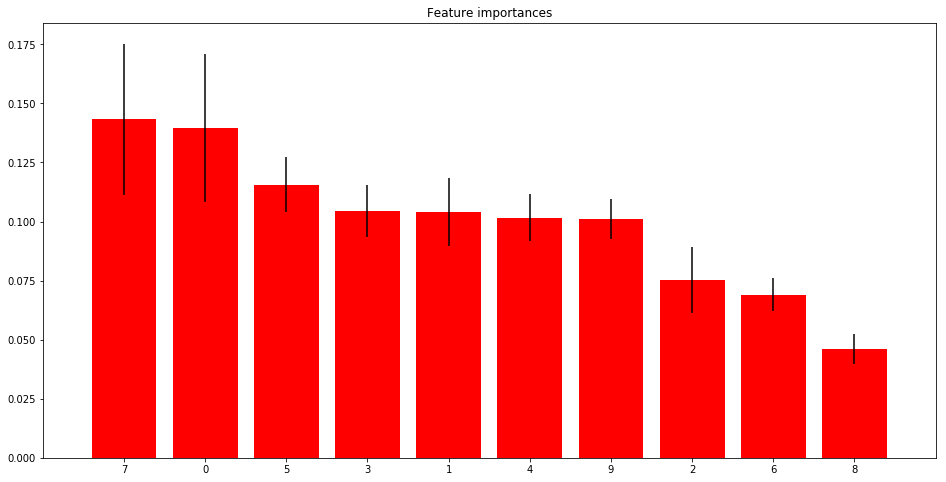

In [19]:
# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=250,
                              random_state=0)

n_features = 10
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(n_features):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,8))
plt.title("Feature importances")
plt.bar(range(n_features), importances[indices][:n_features],
       color="r", yerr=std[indices][:n_features], align="center")
plt.xticks(range(n_features), indices)
plt.xlim([-1, n_features])
plt.show()


Random Forest
Accuracy on training set: 0.976
Accuracy on test set: 0.939

Random Forest Feature Importance


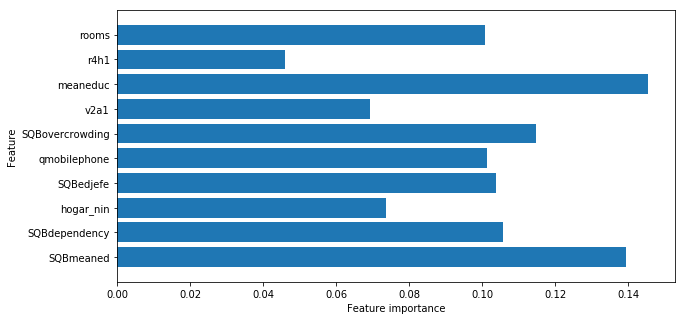

In [23]:
X_train_features = [x for i,x in enumerate(list(ranked_features_df.index))]

def plot_feature_importances_costa(model):
    plt.figure(figsize=(10,5))
    n_features = 10
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
print("")
print('Random Forest')
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

print("")
print('Random Forest Feature Importance')
plot_feature_importances_costa(rf)